In [888]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatGroq(model="gemma2-9b-it")

In [889]:
from IPython.display import Image, display
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict, Annotated

# System message
sys_msg = SystemMessage(content="You are the business analyst and your job is to create user stories based on the requirements")

class State(TypedDict):
    messages: MessagesState
    user_stories: str
    func_document: Annotated[str, "multiple"]  # Allowing multiple values
    tech_document: Annotated[str, "multiple"]  # Allowing multiple values
    code_content: str
    security_comments: str
    test_cases_content: str
    testcases_comments: str
    qa_test_comments: str


def split_into_chunks(text, chunk_size=2000):  
    """Splits text into smaller chunks."""
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

In [ ]:
def writeUserStories(state: State):
    
    last_message = state["messages"]["messages"][-1].content  # Get last human input

    # System message to guide LLM for classification
    classify_msg = SystemMessage(
        content=f"""
        You are a classifier. Your task is to strictly classify the given message as 'requirement' or 'feedback'. 
        If the message suggests dissatisfaction, suggests improvements, or requests rewriting of user stories, 
        classify it as 'feedback'. Otherwise, classify it as 'requirement'.
        
        Return only the word 'requirement' or 'feedback'. 
        
        Message to classify: {last_message}
        """
    )
    print(classify_msg)  # Debugging print

    # Ask LLM to classify
    response = llm.invoke([classify_msg])
    
    if hasattr(response, 'content') and response.content.strip().lower() == 'feedback':
        # Rewrite if it's feedback
        rewrite_msg = SystemMessage(
            content=f"As you are a business analyst, Rewrite the user stories based on the feedback provided: {last_message}"
        )
        result = llm.invoke([rewrite_msg] + state["messages"]["messages"])
        
    else:
        # Process the requirement
        result = llm.invoke([sys_msg] + state["messages"]["messages"])
    
    
    # Append the latest user story to the list
    state["user_stories"] = result.content  

    return {"messages": [result], "user_stories": result.content}


# Human feedback node
def po_feedback(state: State):
    return {"messages": state["messages"]}

# Human feedback node
def design_feedback(state: State):
    return {"messages": state["messages"]}

# Human feedback node
def code_feedback(state: State):
    return {"messages": state["messages"]}

# Human feedback node
def security_feedback(state: State):
    return {"messages": state["messages"]}

# Human feedback node
def testcases_feedback(state: State):
    return {"messages": state["messages"]}

def old_security_feedback(state: State):
    last_message = state["messages"]["messages"][-1].content  # Get last human input


    security_msg = SystemMessage(
            content=f"""You are a Security Expert. Review the following code for potential security vulnerabilities.
        Provide your feedback whether it looks good or not.
        Code to Review:
        {state["code_content"]}

                    """
        )
    
    
    # Ask LLM to classify
    result = llm.invoke([security_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["security_comments"] = result.content  

    return {"messages": [HumanMessage(content=result)], "security_comments": result.content}

def new_security_feedback(state: State):
    last_message = state["messages"]["messages"][-1].content  # Get last human input
    code_content = state["code_content"]

    # Split the code content into chunks
    code_chunks = split_into_chunks(code_content, chunk_size=2000)
    feedback_list = []

    for chunk in code_chunks:
        security_msg = SystemMessage(
            content=f"""Verify and check for any security issues in the following code and provide your feedback based on the code security.
                        Indicate whether it's 'Good' or 'Bad' and provide reasons if it's 'Bad'.
                        Code: {chunk}"""
        )

        # Invoke LLM for each chunk
        result = llm.invoke([security_msg] + state["messages"]["messages"])
        
        if hasattr(result, 'content'):
            feedback_list.append(result.content)
    
    # Combine all feedback into a single response
    combined_feedback = "\n\n".join(feedback_list)
    state["security_comments"] = combined_feedback  

    return {"messages": [HumanMessage(content=combined_feedback)], "security_comments": combined_feedback}


def old_testcases_feedback(state: State):
    last_message = state["messages"]["messages"][-1].content  # Get last human input


    testcases_msg = SystemMessage(
            content=f"""You are a QA analyst, Verify the below testcases and add your comments whether it looks good or not by referring the
            function design document, technical design document and written code.
        
        Tescases to Review:
        {state["test_cases_content"]}

        Refer the following functional Design Document: {state["func_document"]}
        Refer the following Technical Design Document: {state["tech_document"]}
        Refer the following written code: {state["code_content"]}

                    """
        )
    
    
    # Ask LLM to classify
    result = llm.invoke([testcases_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["testcases_comments"] = result.content  

    return {"messages": [HumanMessage(content=result)], "testcases_comments": result.content}

# Decision function for user stories
def evaluate_feedback(state: State) -> list[str]:
    """Use LLM to classify user feedback as 'positive' or 'negative'."""

    last_message = state["messages"]["messages"][-1].content  # Get last human feedback
    print("last_message====>"+last_message)

    # System message to guide LLM
    classify_msg = SystemMessage(
        content="Analyze the following feedback and classify it strictly as 'positive' or 'negative'. "
                "If the feedback suggests dissatisfaction, or rewriting, classify it as 'negative'. "
                "Otherwise, classify it as 'positive'. Return only 'positive' or 'negative' as output.\n"
                f"Feedback: {last_message}"
    )

    # Ask LLM to classify
    response = llm.invoke([classify_msg])

    if hasattr(response, 'content') and response.content:
        decision = response.content.strip().lower()
        print(f"Decision made by evaluator: {decision}")  # Log decision
        if decision == "negative":
            return ["writeUserStories"]
        elif decision == "positive":
            return ["createFuncDesignDocument", "createTechDesignDocument"]
    print("Defaulting to writeUserStories due to unexpected decision.")  # Log fallback case
    return ["writeUserStories"]  # Default if the response is invalid

In [891]:
def createFuncDesignDocument(state: State):
    
    last_message = state["messages"]["messages"][-1].content  # Get last human input

    # Check if the last message came from design_feedback by using a flag in state
    if "from_design_feedback" in state and state["from_design_feedback"] == True:  
        func_msg = SystemMessage(
            content=f""" You are an ETL developer, create a functional design document based on these user stories: {state["user_stories"]}.
            Also, consider the following feedback: {last_message}
            """
        )
    else:
        func_msg = SystemMessage(
            content=f""" You are an ETL developer, create a functional design document based on these user stories: {state["user_stories"]}."""
        )
    

    # Ask LLM to classify
    result = llm.invoke([func_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["func_document"] = result.content  

    return {"messages": [result], "func_document": result.content}

def createTechDesignDocument(state: State):
    
    last_message = state["messages"]["messages"][-1].content  # Get last human input

    # Check if the last message came from design_feedback by using a flag in state
    if "from_design_feedback" in state and state["from_design_feedback"] == True:  
        tech_msg = SystemMessage(
            content=f""" You are an ETL developer, create a technical design document based on these user stories: {state["user_stories"]}.
            Also, consider the following feedback: {last_message}
            """
        )
    else:
        tech_msg = SystemMessage(
            content=f""" You are an ETL developer, create a technical design document based on these user stories: {state["user_stories"]}."""
        )
    

    # Ask LLM to classify
    result = llm.invoke([tech_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["tech_document"] = result.content  

    return {"tech_document": result.content}

# Decision function for user stories
def evaluate_feedback_design(state: State) -> list[str]:
    """Use LLM to classify user feedback as 'positive' or 'negative'."""

    last_message = state["messages"]["messages"][-1].content  # Get last human feedback

    # System message to guide LLM
    classify_msg = SystemMessage(
        content="Analyze the following feedback and classify it strictly as 'positive' or 'negative'. "
                "If the feedback suggests dissatisfaction or rewriting, classify it as 'negative'. "
                "Otherwise, classify it as 'positive'. Return only 'positive' or 'negative' as output.\n"
                f"Feedback: {last_message}"
    )

    # Ask LLM to classify
    response = llm.invoke([classify_msg])

    if hasattr(response, 'content') and response.content:
        decision = response.content.strip().lower()
        print(f"Decision made by evaluator: {decision}")  # Log decision
        if decision == "negative":
            return ["createFuncDesignDocument","createTechDesignDocument"]
        elif decision == "positive":
            return ["GenerateCode"]
    
    return ["writeUserStories"]  # Default if the response is invalid

In [892]:
def old_GenerateCode(state: State):
    
    last_message = state["messages"]["messages"][-1].content  # Get last human input

    # Check if the last message came from design_feedback by using a flag in state
    if "from_code_feedback" in state and state["from_code_feedback"] == True:  
        code_msg = SystemMessage(
            content=f""" You are an ETL developer, Generate code based on following functional and technical design documents: 
            Refer the following functional Design Document: {state["func_document"]}
            Also, refer the following Technical Design Document: {state["tech_document"]}

            consider the following feedback as well: {last_message}
            """
        )
    elif "from_security_feedback" in state and state["from_security_feedback"] == True:  
        code_msg = SystemMessage(
            content=f""" You are an ETL developer, Generate code based on following functional and technical design documents: 
            Refer the following functional Design Document: {state["func_document"]}
            Also, refer the following Technical Design Document: {state["tech_document"]}

            consider the following feedback as well: {state["security_comments"]}
            """
        )
    elif "from_executingTestCases" in state and state["from_executingTestCases"] == True:  
        code_msg = SystemMessage(
            content=f""" You are an ETL developer, Generate code based on following functional and technical design documents: 
            Refer the following functional Design Document: {state["func_document"]}
            Also, refer the following Technical Design Document: {state["tech_document"]}

            consider the following feedback as well: {state["qa_test_comments"]}
            """
        )
    else:
        code_msg = SystemMessage(
            content=f""" You are an ETL developer, Generate code based on following functional and technical design documents: 
            Refer the following functional Design Document: {state["func_document"]}
            Also, refer the following Technical Design Document: {state["tech_document"]}"""
        )
    

    # Ask LLM to classify
    result = llm.invoke([code_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["code_content"] = result.content  

    return {"messages": [result], "code_content": result.content}

def GenerateCode(state: State):
    
    last_message = state["messages"]["messages"][-1].content  # Get last human input

    # Function to summarize content
    def summarize_content(content, role):
        summary_msg = SystemMessage(
            content=f'Summarize the following {role} document to a concise description, retaining key implementation points.\nContent: {content}'
        )
        summary_response = llm.invoke([summary_msg])
        return summary_response.content.strip()

    # Summarize Functional Design Document
    func_summary = summarize_content(state["func_document"], "functional design")

    # Summarize Technical Design Document
    tech_summary = summarize_content(state["tech_document"], "technical design")
    
    # Prepare the prompt based on the state flags
    if "from_code_feedback" in state and state["from_code_feedback"] == True:  
        feedback_content = last_message
    elif "from_security_feedback" in state and state["from_security_feedback"] == True:  
        feedback_content = state["security_comments"]
    elif "from_executingTestCases" in state and state["from_executingTestCases"] == True:  
        feedback_content = state["qa_test_comments"]
    else:
        feedback_content = None  # No additional feedback

    # Prepare the generation message
    if feedback_content:
        code_msg = SystemMessage(
            content=f"""
            You are an ETL developer. Generate code based on the following summarized documents:

            Functional Design Document Summary: {func_summary}
            Technical Design Document Summary: {tech_summary}

            Also, consider the following feedback: {feedback_content}
            """
        )
    else:
        code_msg = SystemMessage(
            content=f"""
            You are an ETL developer. Generate code based on the following summarized documents:

            Functional Design Document Summary: {func_summary}
            Technical Design Document Summary: {tech_summary}
            """
        )

    # Generate code
    result = llm.invoke([code_msg])
    
    # Store the generated code
    state["code_content"] = result.content  

    return {"messages": [result], "code_content": result.content}


# Decision function for user stories
def evaluate_code_feedback(state: State) -> list[str]:
    """Use LLM to classify user feedback as 'positive' or 'negative'."""

    last_message = state["messages"]["messages"][-1].content  # Get last human feedback

    # System message to guide LLM
    classify_msg = SystemMessage(
        content="Analyze the following feedback and classify it strictly as 'positive' or 'negative'. "
                "If the feedback suggests dissatisfaction or rewriting, classify it as 'negative'. "
                "Otherwise, classify it as 'positive'. Return only 'positive' or 'negative' as output.\n"
                f"Feedback: {last_message}"
    )

    # Ask LLM to classify
    response = llm.invoke([classify_msg])

    if hasattr(response, 'content') and response.content:
        decision = response.content.strip().lower()
        print(f"Decision made by evaluator: {decision}")  # Log decision
        if decision == "negative":
            return ["GenerateCode"]
        elif decision == "positive":
            return ["security_feedback"]
    
    return ["GenerateCode"]  # Default if the response is invalid

# Decision function for user stories
def evaluate_security_feedback(state: State) -> list[str]:
    """Use LLM to classify user feedback as 'positive' or 'negative'."""

    last_message = state["messages"]["messages"][-1].content  # Get last human feedback

    # System message to guide LLM
    classify_msg = SystemMessage(
        content="Analyze the following feedback and classify it strictly as 'positive' or 'negative'. "
                "If the feedback suggests dissatisfaction or rewriting, classify it as 'negative'. "
                "Otherwise, classify it as 'positive'. Return only 'positive' or 'negative' as output.\n"
                f"Feedback: {last_message}"
    )

    # Ask LLM to classify
    response = llm.invoke([classify_msg])

    if hasattr(response, 'content') and response.content:
        decision = response.content.strip().lower()
        print(f"Decision made by evaluator: {decision}")  # Log decision
        if decision == "negative":
            return ["GenerateCode"]
        elif decision == "positive":
            return ["writeTestCases"]
    
    return ["GenerateCode"]  # Default if the response is invalid

In [893]:
def old_writeTestCases(state: State):
    
    last_message = state["messages"]["messages"][-1].content  

    # Check if the last message came from design_feedback by using a flag in state
    if "from_test_feedback" in state and state["from_test_feedback"] == True:  
        test_msg = SystemMessage(
            content=f""" You are a QA Analyst, write Test cases by referring the following functional design document, technical design document and code content : 
            Refer the following functional Design Document: {state["func_document"]}
            Refer the following Technical Design Document: {state["tech_document"]}
            Refer the following Written code: {state["code_content"]}

            consider the following feedback as well: {last_message}
            """
        )
    else:
        test_msg = SystemMessage(
            content=f""" You are a QA Analyst, write Test cases by referring the following functional design document, technical design document and code content : 
            Refer the following functional Design Document: {state["func_document"]}
            Refer the following Technical Design Document: {state["tech_document"]}
            Refer the following Written code: {state["code_content"]}

            """
        )
    

    # Ask LLM to classify
    result = llm.invoke([test_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["test_cases_content"] = result.content  

    return {"messages": [result], "test_cases_content": result.content}

# Optimized writeTestCases function

def writeTestCases(state: State):

    last_message = state['messages']['messages'][-1].content  # Get last human feedback

    # Function to summarize content
    def summarize_content(content, role):
        summary_msg = SystemMessage(
            content=f'Summarize the following {role} document to a concise description, retaining key points for writing test cases.\nContent: {content}'
        )
        summary_response = llm.invoke([summary_msg])
        return summary_response.content.strip()

    # Summarize Functional Design Document
    func_summary = summarize_content(state['func_document'], 'functional design')

    # Summarize Technical Design Document
    tech_summary = summarize_content(state['tech_document'], 'technical design')

    # Summarize Code Content
    code_summary = summarize_content(state['code_content'], 'code')

    # Prepare the test case generation message
    if 'from_test_feedback' in state and state['from_test_feedback'] == True:  
        test_msg = SystemMessage(
            content=f"""
            You are a QA Analyst. Write test cases based on the following summaries of documents and code:

            Functional Design Document Summary: {func_summary}
            Technical Design Document Summary: {tech_summary}
            Code Summary: {code_summary}

            Consider the following feedback: {last_message}
            """
        )
    else:
        test_msg = SystemMessage(
            content=f"""
            You are a QA Analyst. Write test cases based on the following summaries of documents and code:

            Functional Design Document Summary: {func_summary}
            Technical Design Document Summary: {tech_summary}
            Code Summary: {code_summary}
            """
        )

    # Generate test cases
    result = llm.invoke([test_msg])

    # Store the generated test cases
    state['test_cases_content'] = result.content  

    return {'messages': [result], 'test_cases_content': result.content}

# Decision function for user stories
def evaluate_test_cases_feedback(state: State) -> list[str]:
    """Use LLM to classify user feedback as 'positive' or 'negative'."""

    last_message = state["messages"]["messages"][-1].content  # Get last human feedback

    # System message to guide LLM
    classify_msg = SystemMessage(
        content="Analyze the following feedback and classify it strictly as 'positive' or 'negative'. "
                "If the feedback suggests dissatisfaction or rewriting, classify it as 'negative'. "
                "Otherwise, classify it as 'positive'. Return only 'positive' or 'negative' as output.\n"
                f"Feedback: {last_message}"
    )

    # Ask LLM to classify
    response = llm.invoke([classify_msg])

    if hasattr(response, 'content') and response.content:
        decision = response.content.strip().lower()
        print(f"Decision made by evaluator: {decision}")  # Log decision
        if decision == "negative":
            return ["writeTestCases"]
        elif decision == "positive":
            return "executingTestCases"
    
    return ["writeTestCases"]  # Default if the response is invalid

In [894]:
def old_executingTestCases(state: State):
    
    last_message = state["messages"]["messages"][-1].content  

    # Check if the last message came from design_feedback by using a flag in state

    exec_msg = SystemMessage(
            content=f""" You are a QA Tester, execute the below test cases and provide your feedback whether its good or not 

            Refer Test cases: {state["test_cases_content"]}
            Refer Code: {state["code_content"]}

            """
        )
    
    # Ask LLM to classify
    result = llm.invoke([exec_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["qa_test_comments"] = result.content  

    return {"messages": [result], "qa_test_comments": result.content}

def executingTestCases(state: State):
    
    # Checking if 'messages' key exists in 'state'
    if "messages" not in state or not isinstance(state["messages"], dict):
        raise TypeError("State is missing 'messages' or 'messages' is not a valid dictionary.")

    # Check if messages are present, otherwise use default message
    if "messages" in state["messages"] and state["messages"]["messages"]:
        last_message = state["messages"]["messages"][-1].content
    else:
        last_message = "good"  # Default message if no messages are found

    # Checking if 'test_cases_content' and 'code_content' exist in state
    if "test_cases_content" not in state or "code_content" not in state:
        raise ValueError("State is missing 'test_cases_content' or 'code_content'.")
    
    # Preparing the message to execute test cases
    exec_msg = SystemMessage(
        content=f""" You are a QA Tester, execute the below test cases and provide your feedback whether it's good or not. 

        Test Cases: {state["test_cases_content"]}
        Code: {state["code_content"]}
        Feedback: {last_message}
        """
    )
    
    # Ask LLM to execute test cases and provide feedback
    result = llm.invoke([exec_msg])
    
    # Storing the feedback in state
    #state["qa_test_comments"] = result.content
    state["qa_test_comments"] = "its good"  

    return {"messages": [result], "qa_test_comments": result.content}



# Decision function for user stories
def evaluate_qa_test_feedback(state: State) -> list[str]:
    """Use LLM to classify user feedback as 'positive' or 'negative'."""

    last_message = state["messages"]["messages"][-1].content  

    # System message to guide LLM
    classify_msg = SystemMessage(
        content="Analyze the following feedback and classify it strictly as 'positive' or 'negative'. "
                "If the feedback suggests dissatisfaction or rewriting the code, classify it as 'negative'. "
                "Otherwise, classify it as 'positive'. Return only 'positive' or 'negative' as output.\n"
                f"Feedback: {last_message}"
    )

    # Ask LLM to classify
    response = llm.invoke([classify_msg])

    if hasattr(response, 'content') and response.content:
        decision = response.content.strip().lower()
        print(f"Decision made by evaluator: {decision}")  # Log decision
        if decision == "negative":
            return ["GenerateCode"]
        elif decision == "positive":
            return END
    
    return ["GenerateCode"]  # Default if the response is invalid

In [895]:
def createTechDesignDocument(state: State):
    
    last_message = state["messages"]["messages"][-1].content  # Get last human input

    # Check if the last message came from design_feedback by using a flag in state
    if "from_design_feedback" in state and state["from_design_feedback"] == True:  
        tech_msg = SystemMessage(
            content=f""" You are an ETL developer, create a technical design document based on these user stories: {state["user_stories"]}.
            Also, consider the following feedback: {last_message}
            """
        )
    else:
        tech_msg = SystemMessage(
            content=f""" You are an ETL developer, create a technical design document based on these user stories: {state["user_stories"]}."""
        )
    

    # Ask LLM to classify
    result = llm.invoke([tech_msg] + state["messages"]["messages"])
    
    # Append the latest functional document to the list
    state["tech_document"] = result.content  

    return {"tech_document": result.content}

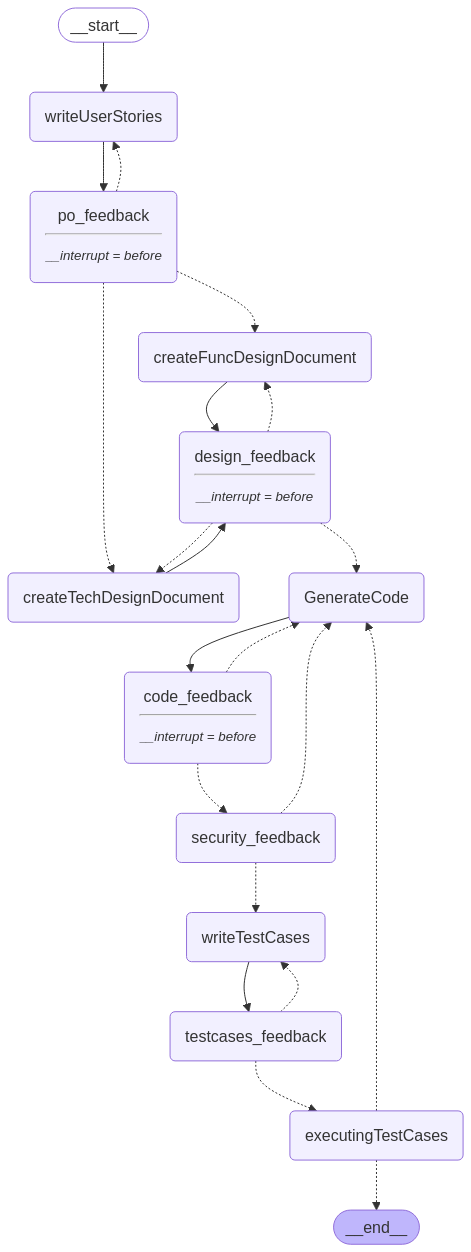

In [898]:

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("writeUserStories", writeUserStories)
builder.add_node("po_feedback", po_feedback)
builder.add_node("design_feedback", design_feedback)
builder.add_node("code_feedback", code_feedback)
builder.add_node("createFuncDesignDocument", createFuncDesignDocument)
builder.add_node("createTechDesignDocument", createTechDesignDocument)
builder.add_node("GenerateCode", GenerateCode)
builder.add_node("security_feedback", security_feedback)
builder.add_node("testcases_feedback", testcases_feedback)
builder.add_node("writeTestCases", writeTestCases)
builder.add_node("executingTestCases", executingTestCases)

builder.add_edge(START,"writeUserStories")
builder.add_edge("writeUserStories","po_feedback")

builder.add_edge("createFuncDesignDocument","design_feedback")
builder.add_edge("createTechDesignDocument","design_feedback")
builder.add_edge("GenerateCode","code_feedback")
builder.add_edge("writeTestCases","testcases_feedback")

#builder.add_conditional_edges("po_feedback",evaluate_feedback,["writeUserStories", "fork_node"])
# Add conditional edges from 'po_feedback' based on user feedback
builder.add_conditional_edges("po_feedback", evaluate_feedback, ["writeUserStories", "createFuncDesignDocument", "createTechDesignDocument"])
builder.add_conditional_edges("design_feedback", evaluate_feedback_design, ["GenerateCode", "createFuncDesignDocument", "createTechDesignDocument"])
builder.add_conditional_edges("code_feedback", evaluate_code_feedback, ["security_feedback", "GenerateCode"])
builder.add_conditional_edges("security_feedback", evaluate_security_feedback, ["writeTestCases", "GenerateCode"])
builder.add_conditional_edges("testcases_feedback", evaluate_test_cases_feedback, ["writeTestCases", "executingTestCases"])
builder.add_conditional_edges("executingTestCases", evaluate_qa_test_feedback, [END, "GenerateCode"])

memory = MemorySaver()
## human in the loop
#graph = builder.compile(interrupt_before=["po_feedback","design_feedback","code_feedback"],checkpointer=memory)
graph = builder.compile(interrupt_before=["po_feedback","design_feedback","code_feedback"],checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))

In [676]:

memory.clear()

AttributeError: 'InMemorySaver' object has no attribute 'clear'

In [899]:
initial_input = {"messages": MessagesState(messages=[HumanMessage(content="The requirement is to transfer employee data file from one directory to another using pyspark")])}
thread={"configurable":{"thread_id":"39"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    print(event)
    #event['messages']['messages']['user_stories'].pretty_print()

{'messages': {'messages': [HumanMessage(content='The requirement is to transfer employee data file from one directory to another using pyspark', additional_kwargs={}, response_metadata={})]}}
content="\n        You are a classifier. Your task is to strictly classify the given message as 'requirement' or 'feedback'. \n        If the message suggests dissatisfaction, suggests improvements, or requests rewriting of user stories, \n        classify it as 'feedback'. Otherwise, classify it as 'requirement'.\n        \n        Return only the word 'requirement' or 'feedback'. \n        \n        Message to classify: The requirement is to transfer employee data file from one directory to another using pyspark\n        " additional_kwargs={} response_metadata={}
{'messages': [AIMessage(content='Certainly! Below is a user story that captures the requirement of transferring employee data files from one directory to another using PySpark.\n\n---\n\n**User Story: Transfer Employee Data File Using 

In [867]:
state=graph.get_state(thread)
state.next

('testcases_feedback',)

In [846]:
state
#state["user_stories"]

StateSnapshot(values={'messages': {'messages': [AIMessage(content='Based on the provided summaries, the following test cases are designed to ensure that all aspects of the ETL process, including data integrity, error handling, logging, performance, and security, are thoroughly tested.\n\n### Test Cases\n\n#### 1. Test Reading Data\n**Test Case ID:** TC01\n**Title:** Verify data reading from the source directory.\n**Preconditions:** Source directory contains valid Parquet files.\n**Steps:**\n1. Call the `read_data` function with the path to the source directory.\n2. Verify that the function reads the data successfully.\n3. Verify that the function handles exceptions (e.g., file not found, permission issues) appropriately.\n\n**Expected Results:**\n- Data is read successfully.\n- Exceptions are handled gracefully with appropriate error messages logged.\n\n#### 2. Test Writing Data\n**Test Case ID:** TC02\n**Title:** Verify data writing to the destination directory.\n**Preconditions:** So

In [904]:
# Update the graph with new feedback
#graph.update_state(thread, {"messages": MessagesState(messages=[HumanMessage(content="It looks good now")])})

# Get the current state
state_snapshot = graph.get_state(thread)
state_values = state_snapshot.values

# Since 'messages' is a list, we directly access and update it
current_messages = state_values["messages"]  # This is a list of messages
print(current_messages)
new_messages = current_messages + [HumanMessage(content="It looks good now")]

updated_messages = MessagesState(messages=new_messages)

# Update the state with the modified messages list
#graph.update_state(thread, {"messages": new_messages})
graph.update_state(thread, {"messages": updated_messages})


state_snapshot = graph.get_state(thread)
state = state_snapshot.values  # Extract the underlying dictionary
print(state)



[AIMessage(content='Based on the provided summaries, here\'s a PySpark script that implements the file transfer process as described:\n\n```python\nfrom pyspark.sql import SparkSession\nimport logging\nfrom datetime import datetime\n\n# Initialize Logger\nlogging.basicConfig(level=logging.INFO)\nlogger = logging.getLogger(__name__)\n\n# Define source and destination paths\nsource_path = "/source/employee_data.csv"\ndestination_path = "/destination/employee_data.csv"\n\ndef main():\n    try:\n        # Initialize Spark session\n        spark = SparkSession.builder.appName("EmployeeDataTransfer").getOrCreate()\n        \n        # Log start time\n        start_time = datetime.now()\n        logger.info(f"Transfer process started at {start_time}")\n        \n        # Read data from source\n        logger.info(f"Reading data from {source_path}")\n        df = spark.read.csv(source_path, header=True, inferSchema=True)\n        \n        # Write data to destination\n        logger.info(f"Wr

In [905]:

for event in graph.stream(None,thread,stream_mode="values"):
    print(event)
    

{'messages': {'messages': [AIMessage(content='Based on the provided summaries, here\'s a PySpark script that implements the file transfer process as described:\n\n```python\nfrom pyspark.sql import SparkSession\nimport logging\nfrom datetime import datetime\n\n# Initialize Logger\nlogging.basicConfig(level=logging.INFO)\nlogger = logging.getLogger(__name__)\n\n# Define source and destination paths\nsource_path = "/source/employee_data.csv"\ndestination_path = "/destination/employee_data.csv"\n\ndef main():\n    try:\n        # Initialize Spark session\n        spark = SparkSession.builder.appName("EmployeeDataTransfer").getOrCreate()\n        \n        # Log start time\n        start_time = datetime.now()\n        logger.info(f"Transfer process started at {start_time}")\n        \n        # Read data from source\n        logger.info(f"Reading data from {source_path}")\n        df = spark.read.csv(source_path, header=True, inferSchema=True)\n        \n        # Write data to destination

ValidationError: 21 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value=AIMessage(content='Great!..., 'total_tokens': 2505}), input_type=AIMessage]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.str
  Input should be a valid string [type=string_type, input_value=('content', 'Great! Let\'...cure and maintainable.'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('content', 'Great! Let\'...cure and maintainable.'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].1.str
  Input should be a valid string [type=string_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].1.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].2.str
  Input should be a valid string [type=string_type, input_value=('response_metadata', {'t...top', 'logprobs': None}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].2.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('response_metadata', {'t...top', 'logprobs': None}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].3.str
  Input should be a valid string [type=string_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].3.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].4.str
  Input should be a valid string [type=string_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].4.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].5.str
  Input should be a valid string [type=string_type, input_value=('id', 'run-79c4839d-08e1...25-a656-6ee0153cf5b2-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].5.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('id', 'run-79c4839d-08e1...25-a656-6ee0153cf5b2-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].6.str
  Input should be a valid string [type=string_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].6.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].7.str
  Input should be a valid string [type=string_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].7.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].8.str
  Input should be a valid string [type=string_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].8.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].9.str
  Input should be a valid string [type=string_type, input_value=('usage_metadata', {'inpu..., 'total_tokens': 2505}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].9.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('usage_metadata', {'inpu..., 'total_tokens': 2505}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type

In [591]:
state_snapshot = graph.get_state(thread)
state = state_snapshot.values  # Extract the underlying dictionary
print(state)

{'messages': [AIMessage(content="Great! \n\nI'm glad you think so. \n\nIf you'd like to move forward and flesh out the functional design document further, I can help with things like:\n\n* **Detailed Data Flow Diagram:**  Visualizing the movement of data from source to destination.\n* **PySpark Code Snippets:**  Illustrating key components of the data transfer logic.\n* **Error Handling Strategies:**  Defining specific actions to take in case of various data transfer issues.\n* **Logging and Monitoring:**  Describing the format and purpose of logs generated during the process.\n* **Security Considerations:**  Addressing any access control or data encryption requirements.\n* **Deployment and Maintenance Plan:**  Outlining how the ETL process will be deployed and kept up-to-date.\n\n\n\nJust let me know what aspects you'd like to explore next!\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 697, 'total_tokens': 877, 'completion_time

In [ ]:
state=graph.get_state(thread)
state_values = state.values  
print(state_values["user_stories"])  
print(state_values["func_document"]) 
print(state_values["tech_document"])
print(state_values["code_content"]) 
print(state_values["test_cases_content"])
#print(state_values["testcases_comments"])
print(state_values["qa_test_comments"])   

Certainly! Here's a user story based on the requirement to transfer employee data files from one directory to another using PySpark.

### User Story: Transfer Employee Data File

**Role:** Data Engineer

**As a** Data Engineer,  
**I want** to transfer employee data files from the source directory to the destination directory using PySpark,  
**So that** the employee data can be processed and utilized in downstream systems.

**Acceptance Criteria:**

1. **File Identification:**
   - The system should identify and read the employee data file located in the source directory.
   
2. **Data Transfer:**
   - The system should use PySpark to transfer the identified employee data file from the source directory to the destination directory.
   
3. **File Naming and Structure:**
   - The file naming convention and structure should be preserved during the transfer.
   
4. **Error Handling:**
   - The system should handle any errors during the transfer process and log the details of the errors fo

KeyError: 'qa_test_comments'

In [512]:
state=graph.get_state(thread)
state.next

()

In [509]:
# Get the current state
state_snapshot = graph.get_state(thread)
state_values = state_snapshot.values

# Since 'messages' is a list, we directly access and update it
current_messages = state_values["messages"]  # This is a list of messages
print(current_messages)
new_messages = current_messages + [HumanMessage(content="It looks good")]

updated_messages = MessagesState(messages=new_messages)

# Update the state with the modified messages list
#graph.update_state(thread, {"messages": new_messages})
graph.update_state(thread, {"messages": updated_messages})


state_snapshot = graph.get_state(thread)
state = state_snapshot.values  # Extract the underlying dictionary
print(state)



[AIMessage(content='Great! Here is a more detailed functional design document based on the user story and acceptance criteria:\n\n### Functional Design Document: Transfer Employee Data File Using PySpark\n\n#### 1. Introduction\nThis document outlines the design for the automated transfer of an employee data file from a source directory to a destination directory using PySpark. The process is designed to be fully automated, ensuring data integrity and providing error handling and logging.\n\n#### 2. Scope\n- **Source Directory:** `/data/employee/source`\n- **Destination Directory:** `/data/employee/destination`\n- **File Naming Convention:** `employee_data_*.csv`\n- **Execution Frequency:** Daily at 2 AM\n\n#### 3. Functional Requirements\n\n##### 3.1 File Identification\n- The system must identify files in the source directory that match the naming convention `employee_data_*.csv`.\n\n##### 3.2 Data Transfer\n- The system must read the identified file from the source directory and tra

In [510]:
for event in graph.stream(None,thread,stream_mode="values"):
    print(event)

{'messages': {'messages': [AIMessage(content='Great! Here is a more detailed functional design document based on the user story and acceptance criteria:\n\n### Functional Design Document: Transfer Employee Data File Using PySpark\n\n#### 1. Introduction\nThis document outlines the design for the automated transfer of an employee data file from a source directory to a destination directory using PySpark. The process is designed to be fully automated, ensuring data integrity and providing error handling and logging.\n\n#### 2. Scope\n- **Source Directory:** `/data/employee/source`\n- **Destination Directory:** `/data/employee/destination`\n- **File Naming Convention:** `employee_data_*.csv`\n- **Execution Frequency:** Daily at 2 AM\n\n#### 3. Functional Requirements\n\n##### 3.1 File Identification\n- The system must identify files in the source directory that match the naming convention `employee_data_*.csv`.\n\n##### 3.2 Data Transfer\n- The system must read the identified file from th

In [ ]:
state=graph.get_state(thread)
state_values = state.values  
print(state_values["user_stories"])  
print(state_values["func_document"]) 
print(state_values["tech_document"])
print(state_values["code_content"])
print(state_values["code_content"])  

Certainly! Here's a user story based on the requirement to transfer employee data files from one directory to another using PySpark:

---

**As a** data administrator,  
**I want to** transfer employee data files from the source directory to the destination directory using PySpark,  
**so that** the data can be processed and analyzed in the correct environment efficiently.

**Acceptance Criteria:**

1. **Data Integrity**: The transferred files must be an exact copy of the original files, ensuring no data loss or corruption.
2. **File Identification**: The system should be able to identify all files related to employee data in the source directory.
3. **Job Logging**: The PySpark job should log the start and end time of the transfer process, along with any errors encountered.
4. **Error Handling**: If a file fails to transfer, the system should log the error and continue processing other files.
5. **Performance**: The transfer should complete within a reasonable time frame, given the si

KeyError: 'code_content'

In [877]:
pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [887]:
import subprocess
import threading
import webbrowser
import time
import os

# Save your Streamlit app to a temporary file
streamlit_code = """
import streamlit as st
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from typing import Dict, Any
import json

# Initialize the graph (using your existing setup)
memory = MemorySaver()
graph = builder.compile(interrupt_before=["po_feedback","design_feedback","code_feedback"], checkpointer=memory)

def reset_session():
    st.session_state.clear()
    st.session_state.thread_id = "1"  # Default thread ID

def display_state(state: Dict[str, Any]):
    \"\"\"Display the current state in an organized way\"\"\"
    with st.expander("Current State Overview"):
        if "user_stories" in state:
            st.subheader("User Stories")
            st.text(state["user_stories"])
        
        if "func_document" in state:
            st.subheader("Functional Design")
            st.text(state["func_document"])
        
        if "tech_document" in state:
            st.subheader("Technical Design")
            st.text(state["tech_document"])
        
        if "code_content" in state:
            st.subheader("Generated Code")
            st.code(state["code_content"], language='python')
        
        if "test_cases_content" in state:
            st.subheader("Test Cases")
            st.text(state["test_cases_content"])
        
        if "qa_test_comments" in state:
            st.subheader("QA Test Results")
            st.text(state["qa_test_comments"])

def main():
    st.title("Software Development Workflow Assistant")
    st.markdown(\"\"\"
    This interactive tool guides you through the complete software development lifecycle:
    1. Requirements → User Stories
    2. Design Documents
    3. Code Implementation
    4. Security Review
    5. Testing
    \"\"\")

    # Initialize session state
    if 'thread_id' not in st.session_state:
        reset_session()
    
    # Sidebar controls
    with st.sidebar:
        st.header("Controls")
        st.text_input("Thread ID", key="thread_id")
        if st.button("New Session"):
            reset_session()
        if st.button("Show Full State"):
            state = graph.get_state({"configurable": {"thread_id": st.session_state.thread_id}})
            st.json(state.values)
    
    # Main interface
    tab1, tab2 = st.tabs(["Workflow", "Configuration"])
    
    with tab1:
        # Step 1: Initial input
        if 'initial_input' not in st.session_state:
            with st.form("initial_input_form"):
                st.subheader("Enter Requirements")
                requirements = st.text_area("Describe your software requirements:", 
                                         "The requirement is to transfer employee data file from one directory to another using pyspark")
                
                if st.form_submit_button("Start Workflow"):
                    initial_input = {
                        "messages": MessagesState(messages=[HumanMessage(content=requirements)])
                    }
                    thread = {"configurable": {"thread_id": st.session_state.thread_id}}
                    
                    # Run initial step
                    for event in graph.stream(initial_input, thread, stream_mode="values"):
                        st.session_state.current_state = event
                    
                    st.session_state.initial_input = True
                    st.session_state.current_step = "po_feedback"
                    st.rerun()
        
        # Subsequent steps
        elif 'current_step' in st.session_state:
            current_step = st.session_state.current_step
            state = graph.get_state({"configurable": {"thread_id": st.session_state.thread_id}})
            
            # Display current state
            display_state(state.values)
            
            # Get human feedback for current step
            with st.form(f"{current_step}_feedback_form"):
                st.subheader(f"Provide Feedback ({current_step.replace('_', ' ')})")
                
                # Show appropriate prompt based on current step
                if current_step == "po_feedback":
                    st.markdown("Review the generated user stories above and provide feedback:")
                elif current_step == "design_feedback":
                    st.markdown("Review the design documents above and provide feedback:")
                elif current_step == "code_feedback":
                    st.markdown("Review the generated code above and provide feedback:")
                elif current_step == "testcases_feedback":
                    st.markdown("Review the test cases above and provide feedback:")
                
                feedback = st.text_area("Your feedback:", "It looks good")
                
                if st.form_submit_button("Submit Feedback"):
                    # Update state with new feedback
                    current_messages = state.values["messages"]
                    new_messages = current_messages + [HumanMessage(content=feedback)]
                    updated_messages = MessagesState(messages=new_messages)
                    
                    graph.update_state(
                        {"configurable": {"thread_id": st.session_state.thread_id}},
                        {"messages": updated_messages}
                    )
                    
                    # Continue the workflow
                    next_events = list(graph.stream(
                        None,
                        {"configurable": {"thread_id": st.session_state.thread_id}},
                        stream_mode="values"
                    ))
                    
                    if next_events:
                        st.session_state.current_state = next_events[-1]
                        
                        # Determine next step (simplified - in reality would check graph structure)
                        if "user_stories" in next_events[-1]:
                            st.session_state.current_step = "po_feedback"
                        elif "func_document" in next_events[-1]:
                            st.session_state.current_step = "design_feedback"
                        elif "code_content" in next_events[-1]:
                            st.session_state.current_step = "code_feedback"
                        elif "test_cases_content" in next_events[-1]:
                            st.session_state.current_step = "testcases_feedback"
                        else:
                            st.session_state.current_step = None
                    
                    st.rerun()
    
    with tab2:
        st.subheader("Workflow Configuration")
        st.markdown(\"\"\"
        ### Workflow Steps:
        1. writeUserStories - Creates user stories from requirements
        2. po_feedback - Product owner feedback on user stories
        3. createFuncDesignDocument - Creates functional design
        4. createTechDesignDocument - Creates technical design
        5. design_feedback - Feedback on design documents
        6. GenerateCode - Implements the code
        7. code_feedback - Developer feedback on code
        8. security_feedback - Security review
        9. writeTestCases - Creates test cases
        10. testcases_feedback - Feedback on test cases
        11. executingTestCases - QA testing
        12. qa_test_feedback - Final approval
        \"\"\")
        
        st.image(graph.get_graph().draw_mermaid_png())

if __name__ == "__main__":
    main()
"""

# Write the Streamlit code to a temp file
with open("temp_streamlit_app.py", "w") as f:
    f.write(streamlit_code)

# Function to run Streamlit in the background
def run_streamlit():
    subprocess.run(["streamlit", "run", "temp_streamlit_app.py"])

# Launch Streamlit in a separate thread
thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# Wait a moment for Streamlit to start
time.sleep(2)

# Open the Streamlit UI in a browser
webbrowser.open("http://localhost:8501")

print("Streamlit app is running! Check your browser.")

Streamlit app is running! Check your browser.


In [884]:
import streamlit as st
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from typing import Dict, Any
import json

# Initialize the graph (using your existing setup)
memory = MemorySaver()
graph = builder.compile(interrupt_before=["po_feedback","design_feedback","code_feedback"], checkpointer=memory)

def reset_session():
    st.session_state.clear()
    st.session_state.thread_id = "1"  # Default thread ID

def display_state(state: Dict[str, Any]):
    """Display the current state in an organized way"""
    with st.expander("Current State Overview"):
        if "user_stories" in state:
            st.subheader("User Stories")
            st.text(state["user_stories"])
        
        if "func_document" in state:
            st.subheader("Functional Design")
            st.text(state["func_document"])
        
        if "tech_document" in state:
            st.subheader("Technical Design")
            st.text(state["tech_document"])
        
        if "code_content" in state:
            st.subheader("Generated Code")
            st.code(state["code_content"], language='python')
        
        if "test_cases_content" in state:
            st.subheader("Test Cases")
            st.text(state["test_cases_content"])
        
        if "qa_test_comments" in state:
            st.subheader("QA Test Results")
            st.text(state["qa_test_comments"])

def main():
    st.title("Software Development Workflow Assistant")
    st.markdown("""
    This interactive tool guides you through the complete software development lifecycle:
    1. Requirements → User Stories
    2. Design Documents
    3. Code Implementation
    4. Security Review
    5. Testing
    """)

    # Initialize session state
    if 'thread_id' not in st.session_state:
        reset_session()
    
    # Sidebar controls
    with st.sidebar:
        st.header("Controls")
        st.text_input("Thread ID", key="thread_id")
        if st.button("New Session"):
            reset_session()
        if st.button("Show Full State"):
            state = graph.get_state({"configurable": {"thread_id": st.session_state.thread_id}})
            st.json(state.values)
    
    # Main interface
    tab1, tab2 = st.tabs(["Workflow", "Configuration"])
    
    with tab1:
        # Step 1: Initial input
        if 'initial_input' not in st.session_state:
            with st.form("initial_input_form"):
                st.subheader("Enter Requirements")
                requirements = st.text_area("Describe your software requirements:", 
                                         "The requirement is to transfer employee data file from one directory to another using pyspark")
                
                if st.form_submit_button("Start Workflow"):
                    initial_input = {
                        "messages": MessagesState(messages=[HumanMessage(content=requirements)])
                    }
                    thread = {"configurable": {"thread_id": st.session_state.thread_id}}
                    
                    # Run initial step
                    for event in graph.stream(initial_input, thread, stream_mode="values"):
                        st.session_state.current_state = event
                    
                    st.session_state.initial_input = True
                    st.session_state.current_step = "po_feedback"
                    st.rerun()
        
        # Subsequent steps
        elif 'current_step' in st.session_state:
            current_step = st.session_state.current_step
            state = graph.get_state({"configurable": {"thread_id": st.session_state.thread_id}})
            
            # Display current state
            display_state(state.values)
            
            # Get human feedback for current step
            with st.form(f"{current_step}_feedback_form"):
                st.subheader(f"Provide Feedback ({current_step.replace('_', ' ')})")
                
                # Show appropriate prompt based on current step
                if current_step == "po_feedback":
                    st.markdown("Review the generated user stories above and provide feedback:")
                elif current_step == "design_feedback":
                    st.markdown("Review the design documents above and provide feedback:")
                elif current_step == "code_feedback":
                    st.markdown("Review the generated code above and provide feedback:")
                elif current_step == "testcases_feedback":
                    st.markdown("Review the test cases above and provide feedback:")
                
                feedback = st.text_area("Your feedback:", "It looks good")
                
                if st.form_submit_button("Submit Feedback"):
                    # Update state with new feedback
                    current_messages = state.values["messages"]
                    new_messages = current_messages + [HumanMessage(content=feedback)]
                    updated_messages = MessagesState(messages=new_messages)
                    
                    graph.update_state(
                        {"configurable": {"thread_id": st.session_state.thread_id}},
                        {"messages": updated_messages}
                    )
                    
                    # Continue the workflow
                    next_events = list(graph.stream(
                        None,
                        {"configurable": {"thread_id": st.session_state.thread_id}},
                        stream_mode="values"
                    ))
                    
                    if next_events:
                        st.session_state.current_state = next_events[-1]
                        
                        # Determine next step (simplified - in reality would check graph structure)
                        if "user_stories" in next_events[-1]:
                            st.session_state.current_step = "po_feedback"
                        elif "func_document" in next_events[-1]:
                            st.session_state.current_step = "design_feedback"
                        elif "code_content" in next_events[-1]:
                            st.session_state.current_step = "code_feedback"
                        elif "test_cases_content" in next_events[-1]:
                            st.session_state.current_step = "testcases_feedback"
                        else:
                            st.session_state.current_step = None
                    
                    st.rerun()
    
    with tab2:
        st.subheader("Workflow Configuration")
        st.markdown("""
        ### Workflow Steps:
        1. writeUserStories - Creates user stories from requirements
        2. po_feedback - Product owner feedback on user stories
        3. createFuncDesignDocument - Creates functional design
        4. createTechDesignDocument - Creates technical design
        5. design_feedback - Feedback on design documents
        6. GenerateCode - Implements the code
        7. code_feedback - Developer feedback on code
        8. security_feedback - Security review
        9. writeTestCases - Creates test cases
        10. testcases_feedback - Feedback on test cases
        11. executingTestCases - QA testing
        12. qa_test_feedback - Final approval
        """)
        
        st.image(graph.get_graph().draw_mermaid_png())

if __name__ == "__main__":
    main()

2025-03-24 22:22:26.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 22:22:26.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 22:22:26.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 22:22:26.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 22:22:26.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 22:22:26.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 22:22:26.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 22:22:26.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [885]:
streamlit run app.py

SyntaxError: invalid syntax (3737097518.py, line 1)